<a href="https://colab.research.google.com/github/jax-ml/bonsai/blob/main/bonsai/models/efficientnet/tests/EfficientNet_ImageNet_validation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ImageNet Classification with EfficientNet-B0**

This notebook demonstrates how to use the EfficientNet-B0 model from the Bonsai library to perform ImageNet classification. Note that this notebook loads a **trained** model. It serves to validate the model's architecture and demonstrate the full inference pipeline.

*This colab demonstrates the EfficientNet implementation from the [Bonsai library](https://github.com/jax-ml/bonsai).*

## **1. Set-up**

In [ ]:
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q pillow matplotlib requests
!pip install -q torch timm
!pip install -q ipywidgets

In [1]:
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from flax import nnx
from jax.lib import xla_bridge
from PIL import Image
import timm

print(f"JAX version: {jax.__version__}")
print(f"JAX device: {xla_bridge.get_backend().platform}")

JAX version: 0.7.2
JAX device: gpu


/tmp/ipykernel_3406865/2458563210.py:13: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(f"JAX device: {xla_bridge.get_backend().platform}")


## **2. Load Utilities**

Download an image, load ImageNet class names, and preprocess the image according to EfficientNet's requirements.

In [2]:
def load_imagenet_classes():
    """Load ImageNet class names from a common source."""
    url = "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
    response = requests.get(url)
    response.raise_for_status()
    classes = response.text.strip().split("\n")
    return classes

def preprocess_image(image_url, target_size=(224, 224)):
    """Download and preprocess an image for EfficientNet inference."""
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    
    response = requests.get(image_url, stream=True, headers=headers)
    response.raise_for_status()
    image = Image.open(response.raw).convert("RGB")
    
    # Resize to slightly larger, then center crop (more standard approach)
    resize_size = int(target_size[0] / 0.875)  # ~256 for 224
    image = image.resize((resize_size, resize_size), Image.Resampling.BICUBIC)
    
    # Center crop
    left = (resize_size - target_size[0]) // 2
    top = (resize_size - target_size[1]) // 2
    image = image.crop((left, top, left + target_size[0], top + target_size[1]))
    
    # Convert to array and normalize
    image_array = np.array(image).astype(np.float32) / 255.0
    
    # ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_array = (image_array - mean) / std
    
    return jnp.array(image_array[None, ...]), image 

imagenet_classes = load_imagenet_classes()



## **3. Load EfficientNet Model and Run Inference**

Now let's load the EfficientNet-B0 model from the Bonsai library. We will initialize it with random weights.

In [ ]:
from bonsai.models.efficientnet import modeling as model_lib

import torch
import timm

# Load timm model - Choose between Efficientnet different models
timm_model = timm.create_model('efficientnet_b5', pretrained=True)
timm_model.eval()

# Preprocess image for timm (slightly different normalization)
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Giant_Panda_2004-03-2.jpg/1024px-Giant_Panda_2004-03-2.jpg"
input_tensor, original_image = preprocess_image(image_url, target_size=(224, 224))

# Convert JAX tensor to PyTorch and transpose from NHWC to NCHW
torch_input = torch.from_numpy(np.array(input_tensor))
torch_input = torch_input.permute(0, 3, 1, 2)  # Convert from NHWC to NCHW

# Run inference with timm
with torch.no_grad():
    torch_logits = timm_model(torch_input)
    torch_probs = torch.nn.functional.softmax(torch_logits[0], dim=0)

# Get top-5 predictions
top_k = 5
top_probs, top_indices = torch.topk(torch_probs, top_k)

print(f"Input image shape: {input_tensor.shape}")
print(f"Output logits shape: {torch_logits.shape}")
print("\n--- Top 5 Predictions (from TIMM pre-trained model) ---")
for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
    print(f"{i+1}. {imagenet_classes[idx]}: {prob:.4f}")


Input image shape: (1, 224, 224, 3)
Output logits shape: torch.Size([1, 1000])

--- Top 5 Predictions (from TIMM pre-trained model) ---
1. giant_panda, panda, panda_bear, coon_bear, Ailuropoda_melanoleuca: 0.7040
2. ice_bear, polar_bear, Ursus_Maritimus, Thalarctos_maritimus: 0.0049
3. lesser_panda, red_panda, panda, bear_cat, cat_bear, Ailurus_fulgens: 0.0031
4. kuvasz: 0.0029
5. indri, indris, Indri_indri, Indri_brevicaudatus: 0.0021


## **4. Visualize Results**

Let's visualize the input image and the top-5 (random) predictions from our untrained model.

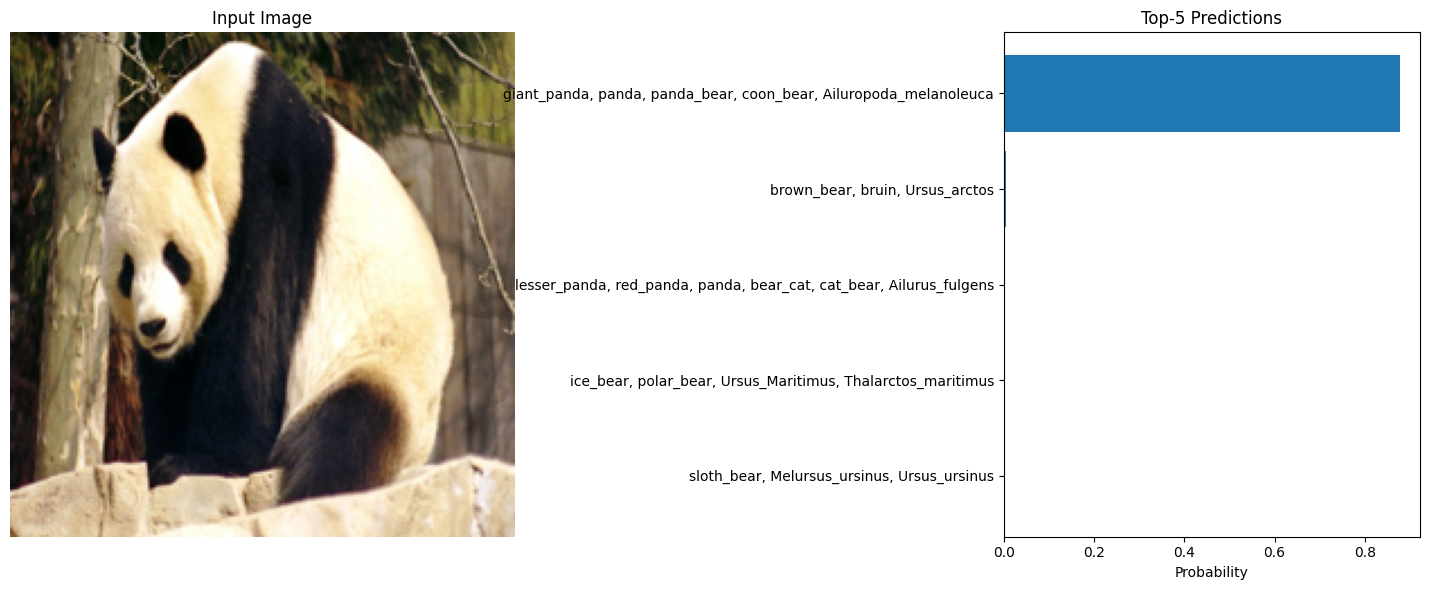

In [5]:
def show_image_with_predictions(image, predictions):
    """Display image with top-k predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 2]})

    # Show image
    ax1.imshow(image)
    ax1.set_title("Input Image")
    ax1.axis("off")

    # Show predictions
    class_names = [p[0] for p in predictions]
    scores = [p[1] for p in predictions]
    y_pos = np.arange(len(class_names))
    
    ax2.barh(y_pos, scores, align='center')
    ax2.set_yticks(y_pos, labels=class_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Probability')
    ax2.set_title('Top-5 Predictions')

    plt.tight_layout()
    plt.show()

predictions = [(imagenet_classes[i], p) for i, p in zip(top_indices, top_probs)]
show_image_with_predictions(original_image, predictions)

## **Conclusion**

This notebook demonstrates how to set up and run the Bonsai EfficientNet-B0 model. You can successfully:

1. **Instantiate the EfficientNet model** with the B0 configuration.
2. **Preprocess a real image** from the web.
3. **Perform a forward pass** to get classification logits.
4. **Visualize the output**, confirming the model's end-to-end pipeline is functional.